<a href="https://colab.research.google.com/github/Hyun-Jun-Lee/News_Analysis/blob/main/text_analysist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

In [ ]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
import datetime
from wordcloud import WordCloud
from pykospacing import Spacing

In [9]:
stopwords = pd.read_csv('/content/drive/MyDrive/stopword.csv')
stopwords.sample(10)

,stopdword
18,에게
553,어떤것들
149,비걱거리다
412,전후
314,이었다
156,여러분
110,대해서
216,콸콸
222,우르르
64,이용하여


In [10]:
data = pd.read_csv('/content/drive/MyDrive/1-8월 뉴스.csv')
data

,title,text,url,media,date
0,무너지는 일과 삶의 경계···노동이 녹아내린다,이 땅에서 ‘비정규직’이라는 표현이 광범위하게 쓰인 지 20여년. 정부가 신규 일자...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
1,일자리 아닌 일거리···'일정치 않음'을 살다 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\n노동의 미래를 모두 알 수는 없다. 다만 현실에서 일어나...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
2,이곳은…기계의 정확도 높이는 ‘인간부품’ 육성공장 아닐까 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\nㆍAI 학습데이터 가공 기업 ‘크라우드웍스’ 교육장 참관...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
3,"지혜씨, 지훈씨를 부탁해! [인포그래픽]",새로 태어나는 아이들은 줄어들고 어르신들은 계속 나이를 먹어 갑니다. 2020년 새...,https://news.naver.com/main/read.nhn?mode=LPOD...,경향신문,2020-01-01
4,"[20대 리포트] “20대, 함부로 판단말라… 내 길 내가 간다”",새천년의 시작과 함께 세상에 나온 2000년대생들이 어느덧 사회 변화를 이끌 20대...,https://news.naver.com/main/read.nhn?mode=LPOD...,국민일보,2020-01-01
...,...,...,...,...,...
29036,"""2.5단계로 무급휴가 요구""… 코로나 재유행에 살아난 '갑질'",직장인 A씨는 수도권 사회적 거리두기 2.5단계를 시행하는 30일부터 다음달 6일...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29037,모호한 조치ㆍ 깜깜이 환자 비율 40%육박... 거리두기 2.5단계 효과 있을까,"30일 0시부터 서울 전역에 강화된 사회적 거리두기(2.5단계)가 시행됐지만, 전문...",https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29038,내일부터 서울 시내버스 밤 9시 이후 20% 감축… 주말 수준으로,수도권의 ‘사회적 거리두기’ 2.5단계 시행 기간에 맞춰 서울 시내버스의 야간 운행...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31
29039,집단휴업 두고 전공의 vs 정부 '강대강 대치'... 의료공백 장기화 불가피,21일부터 10일째 무기한 집단휴진을 이어가고 있는 전공의(인턴ㆍ레지던트)들과 정부...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,2020-08-31


In [37]:
data.isna().sum()

title    0
text     0
url      0
media    0
date     0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29041 entries, 0 to 29040
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   29041 non-null  object
 1   text    29041 non-null  object
 2   url     29041 non-null  object
 3   media   29041 non-null  object
 4   date    29041 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [36]:
data['media'].value_counts()

경향신문    3715
세계일보    3636
조선일보    3435
동아일보    3316
한국일보    3073
문화일보    2891
서울신문    2817
국민일보    2320
한겨레     2276
중앙일보    1562
Name: media, dtype: int64

In [11]:
# 'date' 컬럼 datetime 형으로 변환 후 월일 형태로
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.strftime('%m/%d')
data.sample(5)

,title,text,url,media,date
15738,"총선 참패 한 달…통합당, 혁신은커녕 ‘우왕좌왕’",패인 분석 등 아직 첫발도 떼지 못한 상황 / 지난주 정당지지도 26.1%… 창당 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,세계일보,05/14
24421,포천 8사단 코로나 14명 집단감염 '미스터리',경기 포천의 육군 8사단 소속 장병 14명이 무더기로 신종 코로나바이러스 감염증(코...,https://news.naver.com/main/read.nhn?mode=LPOD...,한국일보,07/23
10679,"피말리는 수도권… 민주 ""121석 중 최소 90석"" 통합 ""50석 넘겨 1당""","[4·15 총선]\n- '지역구 의석 절반' 걸린 서울·경기·인천\n민주당 ""76곳...",https://news.naver.com/main/read.nhn?mode=LPOD...,조선일보,04/02
9160,이란 교민 80명 도착…2명 유증상,코로나19 확진자와 사망자가 급증하고 있는 이란에서 한국 교민 등 80명을 태우고 ...,https://news.naver.com/main/read.nhn?mode=LPOD...,한겨레,03/20
15751,"경기도·경찰, 廣州 '나눔의집' 후원금 의혹도 조사",할머니 식비를 직원들 함께 써\n\n\n\t\t\t\t경기도가 위안부 피해자 할머니...,https://news.naver.com/main/read.nhn?mode=LPOD...,조선일보,05/14


In [12]:
# 필요한 column만
df = data[['title','text','date']]
df

,title,text,date
0,무너지는 일과 삶의 경계···노동이 녹아내린다,이 땅에서 ‘비정규직’이라는 표현이 광범위하게 쓰인 지 20여년. 정부가 신규 일자...,01/01
1,일자리 아닌 일거리···'일정치 않음'을 살다 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\n노동의 미래를 모두 알 수는 없다. 다만 현실에서 일어나...,01/01
2,이곳은…기계의 정확도 높이는 ‘인간부품’ 육성공장 아닐까 [녹아내리는 노동],ㆍ①일자리보다 일거리\n\nㆍAI 학습데이터 가공 기업 ‘크라우드웍스’ 교육장 참관...,01/01
3,"지혜씨, 지훈씨를 부탁해! [인포그래픽]",새로 태어나는 아이들은 줄어들고 어르신들은 계속 나이를 먹어 갑니다. 2020년 새...,01/01
4,"[20대 리포트] “20대, 함부로 판단말라… 내 길 내가 간다”",새천년의 시작과 함께 세상에 나온 2000년대생들이 어느덧 사회 변화를 이끌 20대...,01/01
...,...,...,...
29036,"""2.5단계로 무급휴가 요구""… 코로나 재유행에 살아난 '갑질'",직장인 A씨는 수도권 사회적 거리두기 2.5단계를 시행하는 30일부터 다음달 6일...,08/31
29037,모호한 조치ㆍ 깜깜이 환자 비율 40%육박... 거리두기 2.5단계 효과 있을까,"30일 0시부터 서울 전역에 강화된 사회적 거리두기(2.5단계)가 시행됐지만, 전문...",08/31
29038,내일부터 서울 시내버스 밤 9시 이후 20% 감축… 주말 수준으로,수도권의 ‘사회적 거리두기’ 2.5단계 시행 기간에 맞춰 서울 시내버스의 야간 운행...,08/31
29039,집단휴업 두고 전공의 vs 정부 '강대강 대치'... 의료공백 장기화 불가피,21일부터 10일째 무기한 집단휴진을 이어가고 있는 전공의(인턴ㆍ레지던트)들과 정부...,08/31


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29041 entries, 0 to 29040
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   29041 non-null  object
 1   text    29041 non-null  object
 2   date    29041 non-null  object
dtypes: object(3)
memory usage: 680.8+ KB


In [13]:
# 한글,공백 제외하고 제거
df['title'] = df['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,text,date
15302,이태원 확진 명 급증 클럽 방문자 명까지 늘어,일 만에 부산충청제주까지 감염 속출클럽주점 다녀간 명은 연락 안 돼하루 신규 확진 ...,05/11
17724,미중 갈등 와중 성주 사드 기지에 한밤 기습 장비 반입,노후 유도탄 등 교체 경찰과 충돌 주민 명 부상정부가 경북 성주군에 주한미군의 고고...,05/30
16169,문 대통령 평범한 사람의 연대 오월정신이 코로나 극복 저력,문재인 대통령은 일 민주화운동 주년 기념식 기념사에서 진상규명과 함께 오월정신을 화...,05/19
15422,방역 모델 국제표준화 등록 추진,대통령 비공개 수보회의 주재 표준안 마련 순차적 제안 계획 주요 시도별 전담...,05/12
10102,코로나 모범국 경제실정 심판,총선 후보등록 마감 프레임 전쟁 돌입 코로나와 전쟁서 승리 절망의 경제에 희망...,03/28
2290,의원평가 하위 통보선 이상 상당수 포함된 듯,명단 외부 공개는 안 하기로 이해찬 더불어민주당 대표와 참석자들이 일 서울 여...,01/21
26745,올 고가주택 실거래 조사결과 이달중 발표,부총리 부동산 점검회의 불법확인땐 국세청 등 통보 공공재건축 단지 월 선정 부...,08/12
14657,단독한국군 외출 재개에 주한미군 규정 따라야,연합사 장병 출입제한될 수도 주한미군 국방부에 문제 제기코로나 거리두기 완화 엇박자...,05/06
25143,미국 나바호족의 코로나 대반전,경향신문 미국에서 최근 아메리카 원주민 나바호족의 코로나 방역 관리에 대한 관심이 ...,07/30
20514,이소영 년까지 탄소 제로사회 실현 그린뉴딜 기본법이 출발점,초선 이 법을 말하다 이소영 더불어민주당 의원그린뉴딜 기본법 준비 동분서주저는 환경...,06/22


## title 명사 추출

In [14]:
okt = Okt()

In [31]:
title_nouns = []
for sentence in tqdm(df['title']):
    tokenized_sentence = okt.nouns(sentence) # 명사만 추출
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    title_nouns.append(stopwords_removed_sentence)

100%|██████████| 29041/29041 [01:06<00:00, 436.22it/s]


In [32]:
# 한글자 (년,명,월 등)은 제외
title_nouns_list = []
for li in title_nouns:
    for n in li:
        if len(n)>1:
            title_nouns_list.append(n)

### Wordcloud 시각화

In [35]:
# 명사 빈도
count = Counter(title_nouns_list)
title_nouns_cnt = count.most_common(10)
for i in title_nouns_cnt:
    print(i)

('코로나', 2912)
('정부', 1194)
('대통령', 1081)
('감염', 998)
('통합', 989)
('한국', 976)
('확산', 935)
('비상', 912)
('단독', 752)
('확진', 697)


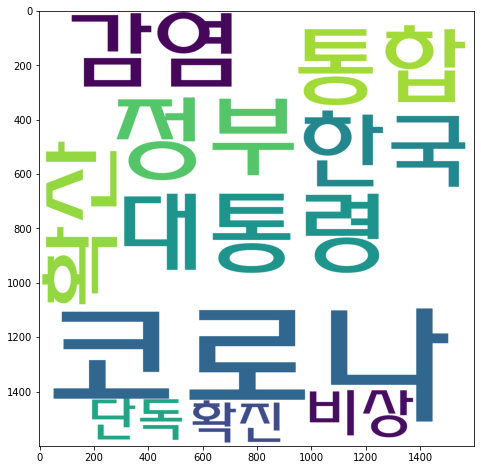

In [56]:
wc = WordCloud(font_path='/content/drive/MyDrive/HYSUPM.TTF', background_color='white',width=800, height=800, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(dict(title_nouns_cnt))
plt.figure(figsize=(10,8))
plt.imshow(gen)

## 코로나 일별 확진자 data 추가

In [56]:
covid = pd.read_csv('/content/drive/MyDrive/전국코로나확진자추이.csv',encoding='cp949')
covid.rename(columns={'날짜':'date'}, inplace=True)
covid.drop(columns=['확진자수'], inplace= True)
covid

,date,일일 확진자
0,2020.03.02,3736
1,2020.03.03,1075
2,2020.03.04,517
3,2020.03.05,438
4,2020.03.06,518
...,...,...
178,2020.08.27,441
179,2020.08.28,371
180,2020.08.29,323
181,2020.08.30,299


In [57]:
# 'date' 컬럼 datetime 형으로 변환 후 월일 형태로
covid['date'] = pd.to_datetime(covid['date'])
covid['date'] = covid['date'].dt.strftime('%m/%d')
covid = covid[covid['date']>"03/02"]
covid = covid[covid['일일 확진자']<1000]
covid

,date,일일 확진자
2,03/04,517
3,03/05,438
4,03/06,518
5,03/07,483
6,03/08,367
...,...,...
178,08/27,441
179,08/28,371
180,08/29,323
181,08/30,299


In [58]:
test_covid = covid.sort_values(by='일일 확진자').tail(20)
test_covid

,date,일일 확진자
182,08/31,248
7,03/09,248
175,08/24,266
167,08/16,279
176,08/25,280
171,08/20,288
170,08/19,297
181,08/30,299
177,08/26,320
180,08/29,323


In [59]:
test_df  = pd.merge(df, test_covid, how='inner', on='date')
test_df

,title,text,date,일일 확진자
0,코로나 뒤 한달벌이 만원하늘만 쳐다봐요,국가 전체가 힘들겠지만 저는 진짜 하늘만 쳐다봐야 해요전북 군산에서 아이돌보미로 일...,03/04,517
1,마스크 공적 판매 약국으로 일원화문 대통령 불편 송구 거듭 사과,전산망 활용 중복 구매 방지 가능문 대통령 정부 시간 체제 전환홍남기 취약계층 무상...,03/04,517
2,도쿄 올림픽 이제 일본에서도 연기설 솔솔 코로나 확산 비상,조직위는 강행 방침 재확인담당상 년 중이면 가능바이러스 대책 우려 목소리일 이사회...,03/04,517
3,북한 김여정 본인 명의 첫 담화 발표화력전투훈련은 자위적 행동 청와대의 우려 표명에 경악,김정은 직접 지도 대만족북한 김정은 국무위원장 여동생인 김여정 노동당 제부부장사진이...,03/04,517
4,프레임 최인철 박남춘의 내 인생의 책,리프레임친구 혹은 가족과 함께 여행을 떠나본 적이 있는가 스마트폰의 일반화로 여행지...,03/04,517
...,...,...,...,...
1775,거리두기 단계로 서비스업소비충격 재현되나,수도권을 중심으로 사회적 거리두기 단계가 시행되면서 신종 코로나바이러스 감염증코로나...,08/31,248
1776,단계로 무급휴가 요구 코로나 재유행에 살아난 갑질,직장인 씨는 수도권 사회적 거리두기 단계를 시행하는 일부터 다음달 일까지 일간 무...,08/31,248
1777,모호한 조치깜깜이 환자 비율 육박 거리두기 단계 효과 있을까,일 시부터 서울 전역에 강화된 사회적 거리두기단계가 시행됐지만 전문가들은 기대한 만...,08/31,248
1778,집단휴업 두고 전공의 정부 강대강 대치 의료공백 장기화 불가피,일부터 일째 무기한 집단휴진을 이어가고 있는 전공의인턴레지던트들과 정부의 갈등이 벼...,08/31,248


## 기존 df 정리

In [17]:
df = df[df['date']>'03/02']
df

,title,text,date
6866,대구경북 신천지 교인 전수검사 끝나가지만전국 산발적 집단감염 못 막으면 장기화 우려,충남부산서 확진자 다수 접촉 등대구경북 외 지역서 감염 증가세당국 일부 지역 소규모...,03/03
6867,일 만에북 미사일 발사 재개,동해로 단거리 탄도미사일 발군 김정은 원산행참관한 듯청서 긴급 장관회의 북 중단을북...,03/03
6868,당정 추경 메르스 때보다 많게조 이상 편성 결정,주 중 제출일까지 국회서 처리아동양육쿠폰 예산 등 우선 반영이낙연 추경 총 조원 넘...,03/03
6869,월일 선거철 밥 한끼 잘못 먹으면 훅 간다 오래 전 이날,년부터 년까지 년마다 경향신문의 같은 날 보도를 살펴보는 코너입니다 매일 업데이트합...,03/03
6870,대구 확진자 여명 입원 대기주말까지 병상 확보 코로나 확산 비상,자가격리 경증환자 위한 생활치료센터 가동삼성 영덕연수원 등 곳 확보시장 실 추가 확...,03/03
...,...,...,...
29036,단계로 무급휴가 요구 코로나 재유행에 살아난 갑질,직장인 씨는 수도권 사회적 거리두기 단계를 시행하는 일부터 다음달 일까지 일간 무...,08/31
29037,모호한 조치깜깜이 환자 비율 육박 거리두기 단계 효과 있을까,일 시부터 서울 전역에 강화된 사회적 거리두기단계가 시행됐지만 전문가들은 기대한 만...,08/31
29038,내일부터 서울 시내버스 밤 시 이후 감축 주말 수준으로,수도권의 사회적 거리두기 단계 시행 기간에 맞춰 서울 시내버스의 야간 운행이 감축...,08/31
29039,집단휴업 두고 전공의 정부 강대강 대치 의료공백 장기화 불가피,일부터 일째 무기한 집단휴진을 이어가고 있는 전공의인턴레지던트들과 정부의 갈등이 벼...,08/31


In [18]:
# 중복 데이터 정리
df.drop_duplicates(subset=['text'], inplace=True)
df.drop_duplicates(subset=['title'], inplace=True)
df.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
Int64Index: 21713 entries, 6866 to 29040
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21713 non-null  object
 1   text    21713 non-null  object
 2   date    21713 non-null  object
dtypes: object(3)
memory usage: 678.5+ KB


In [19]:
# 코로나가 언급된 기사들만
df = df[df['text'].str.contains('코로나')]
df

,title,text,date
6866,대구경북 신천지 교인 전수검사 끝나가지만전국 산발적 집단감염 못 막으면 장기화 우려,충남부산서 확진자 다수 접촉 등대구경북 외 지역서 감염 증가세당국 일부 지역 소규모...,03/03
6867,일 만에북 미사일 발사 재개,동해로 단거리 탄도미사일 발군 김정은 원산행참관한 듯청서 긴급 장관회의 북 중단을북...,03/03
6868,당정 추경 메르스 때보다 많게조 이상 편성 결정,주 중 제출일까지 국회서 처리아동양육쿠폰 예산 등 우선 반영이낙연 추경 총 조원 넘...,03/03
6870,대구 확진자 여명 입원 대기주말까지 병상 확보 코로나 확산 비상,자가격리 경증환자 위한 생활치료센터 가동삼성 영덕연수원 등 곳 확보시장 실 추가 확...,03/03
6871,알바비 기부한 대학생자가격리 장애인에 기부 릴레이도 코로나 확산 비상,재학생졸업생들 연대 모금쌀 같은 구호품 사용 어려워컵밥조미 김 등 간편식 보내코로나...,03/03
...,...,...,...
29035,거리두기 단계로 서비스업소비충격 재현되나,수도권을 중심으로 사회적 거리두기 단계가 시행되면서 신종 코로나바이러스 감염증코로나...,08/31
29036,단계로 무급휴가 요구 코로나 재유행에 살아난 갑질,직장인 씨는 수도권 사회적 거리두기 단계를 시행하는 일부터 다음달 일까지 일간 무...,08/31
29037,모호한 조치깜깜이 환자 비율 육박 거리두기 단계 효과 있을까,일 시부터 서울 전역에 강화된 사회적 거리두기단계가 시행됐지만 전문가들은 기대한 만...,08/31
29039,집단휴업 두고 전공의 정부 강대강 대치 의료공백 장기화 불가피,일부터 일째 무기한 집단휴진을 이어가고 있는 전공의인턴레지던트들과 정부의 갈등이 벼...,08/31


In [20]:
covid_df = pd.merge(df, covid, how='inner', on='date')
covid_df

,title,text,date,일일 확진자
0,대구경북 신천지 교인 전수검사 끝나가지만전국 산발적 집단감염 못 막으면 장기화 우려,충남부산서 확진자 다수 접촉 등대구경북 외 지역서 감염 증가세당국 일부 지역 소규모...,03/03,1075
1,일 만에북 미사일 발사 재개,동해로 단거리 탄도미사일 발군 김정은 원산행참관한 듯청서 긴급 장관회의 북 중단을북...,03/03,1075
2,당정 추경 메르스 때보다 많게조 이상 편성 결정,주 중 제출일까지 국회서 처리아동양육쿠폰 예산 등 우선 반영이낙연 추경 총 조원 넘...,03/03,1075
3,대구 확진자 여명 입원 대기주말까지 병상 확보 코로나 확산 비상,자가격리 경증환자 위한 생활치료센터 가동삼성 영덕연수원 등 곳 확보시장 실 추가 확...,03/03,1075
4,알바비 기부한 대학생자가격리 장애인에 기부 릴레이도 코로나 확산 비상,재학생졸업생들 연대 모금쌀 같은 구호품 사용 어려워컵밥조미 김 등 간편식 보내코로나...,03/03,1075
...,...,...,...,...
10463,거리두기 단계로 서비스업소비충격 재현되나,수도권을 중심으로 사회적 거리두기 단계가 시행되면서 신종 코로나바이러스 감염증코로나...,08/31,248
10464,단계로 무급휴가 요구 코로나 재유행에 살아난 갑질,직장인 씨는 수도권 사회적 거리두기 단계를 시행하는 일부터 다음달 일까지 일간 무...,08/31,248
10465,모호한 조치깜깜이 환자 비율 육박 거리두기 단계 효과 있을까,일 시부터 서울 전역에 강화된 사회적 거리두기단계가 시행됐지만 전문가들은 기대한 만...,08/31,248
10466,집단휴업 두고 전공의 정부 강대강 대치 의료공백 장기화 불가피,일부터 일째 무기한 집단휴진을 이어가고 있는 전공의인턴레지던트들과 정부의 갈등이 벼...,08/31,248


<BarContainer object of 183 artists>

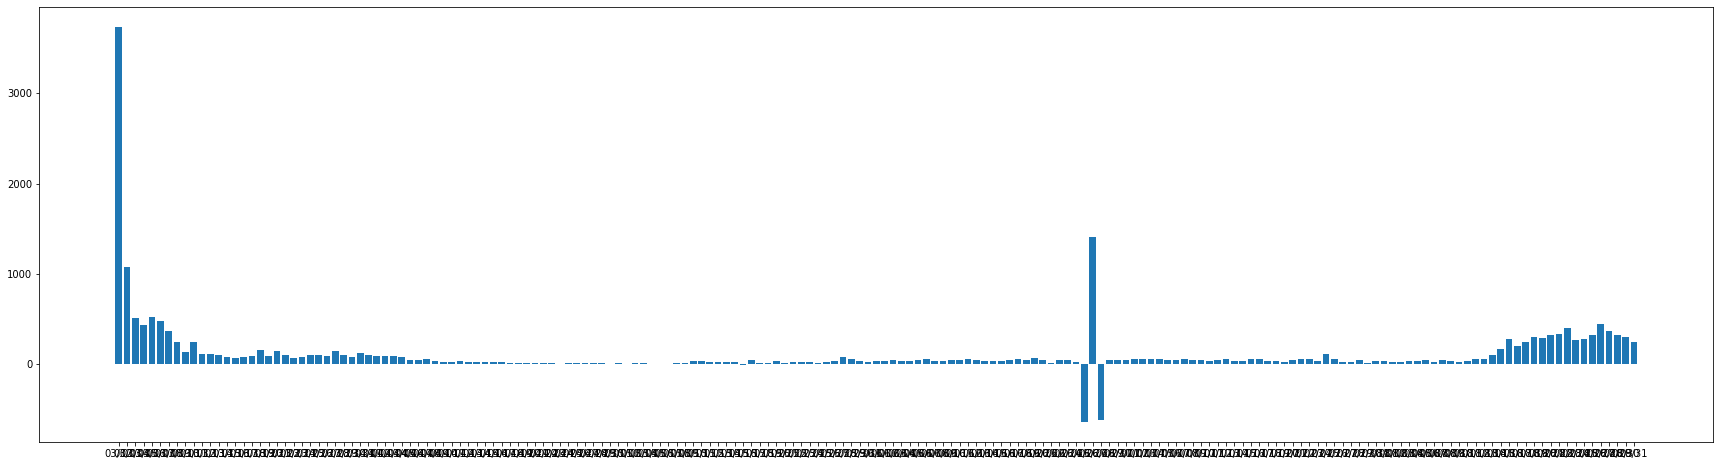

In [39]:
plt.figure(figsize=(30,8))
plt.bar(covid['date'],covid['일일 확진자'])

In [27]:
print('최대 길이 :',max(len(l) for l in covid_df['text']))
print('평균 길이 :',sum(map(len, covid_df['text']))/len(covid_df['text']))

최대 길이 : 11424
평균 길이 : 1381.7307030951472


In [28]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇%인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [40]:
max_len=1700
below_threshold_len(max_len, covid_df['text'])

전체 샘플 중 길이가 1700 이하인 샘플의 비율: 76.81505540695453


In [32]:
for i in covid_df['text']:
    

KeyError: ignored

## 띄어쓰기 + 문장 분리

In [7]:
spacing = Spacing()

In [25]:
ar = []
for i in tqdm(covid_df['text']):
    ar.append(spacing(i))


  1%|          | 71/10468 [00:27<1:06:25,  2.61it/s]


KeyboardInterrupt: ignored

In [55]:
covid_df['spacing'] = S

,title,text,date,일일 확진자
0,대구경북 신천지 교인 전수검사 끝나가지만전국 산발적 집단감염 못 막으면 장기화 우려,충남부산서 확진자 다수 접촉 등대구경북 외 지역서 감염 증가세당국 일부 지역 소규모...,03/03,1075
1,일 만에북 미사일 발사 재개,동해로 단거리 탄도미사일 발군 김정은 원산행참관한 듯청서 긴급 장관회의 북 중단을북...,03/03,1075
2,당정 추경 메르스 때보다 많게조 이상 편성 결정,주 중 제출일까지 국회서 처리아동양육쿠폰 예산 등 우선 반영이낙연 추경 총 조원 넘...,03/03,1075
3,대구 확진자 여명 입원 대기주말까지 병상 확보 코로나 확산 비상,자가격리 경증환자 위한 생활치료센터 가동삼성 영덕연수원 등 곳 확보시장 실 추가 확...,03/03,1075
4,알바비 기부한 대학생자가격리 장애인에 기부 릴레이도 코로나 확산 비상,재학생졸업생들 연대 모금쌀 같은 구호품 사용 어려워컵밥조미 김 등 간편식 보내코로나...,03/03,1075
...,...,...,...,...
10463,거리두기 단계로 서비스업소비충격 재현되나,수도권을 중심으로 사회적 거리두기 단계가 시행되면서 신종 코로나바이러스 감염증코로나...,08/31,248
10464,단계로 무급휴가 요구 코로나 재유행에 살아난 갑질,직장인 씨는 수도권 사회적 거리두기 단계를 시행하는 일부터 다음달 일까지 일간 무...,08/31,248
10465,모호한 조치깜깜이 환자 비율 육박 거리두기 단계 효과 있을까,일 시부터 서울 전역에 강화된 사회적 거리두기단계가 시행됐지만 전문가들은 기대한 만...,08/31,248
10466,집단휴업 두고 전공의 정부 강대강 대치 의료공백 장기화 불가피,일부터 일째 무기한 집단휴진을 이어가고 있는 전공의인턴레지던트들과 정부의 갈등이 벼...,08/31,248
